This code is a modified version of @filthyQuants code from tik tok, the original code backtested a 50 day moving average strategy. I have expanded it to consider other strategies such as an exponential moving average, a crossover moving average and and a coin flip strategy.


In [270]:
import yfinance as yf
import pandas   as pd
import numpy    as np
import random

If you interested in the way this code works you can find each of the strategies and the code to implement them below. If you arent scroll down to see the implementation to mess around with the various parameters.

In [271]:
#First we need to retreive the data to do any of the testing against. 

def getdata(stockname,testperiod):
    yfdata = yf.Ticker("{}".format(stockname)).history(period=str(testperiod))
    closedata = yfdata['Close'].copy()
    return closedata

In [272]:
#Defining a function to take the moving cost averages, in this case we will do it over 50 days. The days is letting you set the number of days

def sma(data_levels,days = 50, tollerence = 0.001):
    
    #First we turn it into a data frame. 
    
    data = pd.DataFrame(data_levels).copy()
    
    #Second we take the data and add a new collumn that has the moving cost average where we will name the new collumn SMA with the 
    # subscript of the number of days being considred
    
    data['SMA_{}'.format(days)]  = data.iloc[:,0].rolling(days).mean()
    
    #Create a new collumn that has a the 'returns', this will be the percentage change day on dat of theflat price of the coin. 
    
    data['Returns'] = data.iloc[:,0].pct_change() 
    
    #house keeping to get rid of any empty collumns, 
    
    data = data.dropna()
    
    #make a list to store the signal data, 

    signals = []
    
    #loop through ther data and if the rolling close average and compares it to the closing price that day. 

    for i in range(len(data)):
        
        ## if Current price > SMA = buy
        if data.iloc[:,0].iloc[i] > data.iloc[:,1].iloc[i] + tollerence*data.iloc[:,0].iloc[i]:
            signals.append(1)
        
        # if Current price < SMA = sell
        elif data.iloc[:,0].iloc[i] + tollerence*data.iloc[:,0].iloc[i] < data.iloc[:,1].iloc[i] +tollerence*data.iloc[:,0].iloc[i]:
            signals.append(-1)
            
        # if Current Price is too close to SMA we wont do anything. = do nothing (this wont happen)
        else: #data.iloc[:,0].iloc[i] == data.iloc[:,1].iloc[i]:
            #print('test')
            signals.append(0)
            
    data['Signals'] = signals
    return data

In [273]:
#Defining a function to take the exponential moving cost averages, in this case we will do it over 50 days. The days is letting you set the number of days

def ema(data_levels,days = 50, tollerence = 0.001):
    
    #First we turn it into a data frame. 
    
    data = pd.DataFrame(data_levels).copy()
    
    #make a new collumn that has exponential weighted average. EWM method in pandas makes this super easy
    
    data['EMA_{}'.format(days)] = data.iloc[:,0].ewm(span = days).mean()   
    
    #Create a new collumn that has a the 'returns', this will be the percentage change day on day of theflat price of the coin. 
    
    data['Returns'] = data.iloc[:,0].pct_change() 
    
    #house keeping to get rid of any empty rows, 
    
    data = data.dropna()
    
    #make a list to store the signal data, 

    signals = []
    
    #loop through ther data and if the rolling close average and compares it to the closing price that day. 

    for i in range(len(data)):
        
        ## if Current price > EMA + tollerance = buy
        if data.iloc[:,0].iloc[i] > data.iloc[:,1].iloc[i] + tollerence*data.iloc[:,0].iloc[i]:
            signals.append(1)
        
        # if if Current price + tollerance < EMA = sell
        elif data.iloc[:,0].iloc[i] + tollerence*data.iloc[:,0].iloc[i]< data.iloc[:,1].iloc[i]:
            signals.append(-1)
            
        # if EMA is too close to current price = do nothing
        else: #data.iloc[:,0].iloc[i] == data.iloc[:,1].iloc[i]:
            #print('test')
            signals.append(0)
            
    data['Signals'] = signals
    
    return data

In [274]:
#Defining a function to find the signals of a moving crossover strategy

def mxa(data_levels,daysshort = 50, dayslong =200, tollerence = 0.001):
    
    #First we turn it into a data frame. 
    
    data = pd.DataFrame(data_levels).copy()
    
    #make a new collumn that has the 50 day average
    
    data['SMA_{}'.format(daysshort)]  = data.iloc[:,0].rolling(daysshort).mean()
    
    #make another that has the 200 day average 
    
    data['SMA_{}'.format(dayslong)]  = data.iloc[:,0].rolling(dayslong).mean()
    
    #Create a new collumn that has a the 'returns', this will be the percentage change day on day of theflat price of the coin. 
    
    data['Returns'] = data.iloc[:,0].pct_change() 
    
    #house keeping to get rid of any empty rows, 
    
    data = data.dropna()
    
    #make a list to store the signal data, 

    signals = []
    
    #loop through ther data and if the rolling close average and compares it to the closing price that day. 

    for i in range(len(data)):
        
        ## if 50 day average > 200 day average = buy
        if data['SMA_{}'.format(daysshort)].iloc[i] > data['SMA_{}'.format(dayslong)].iloc[i]:
            signals.append(1)
        
        # if 50 day average < 200 day average = sell
        elif data['SMA_{}'.format(daysshort)].iloc[i] < data['SMA_{}'.format(dayslong)].iloc[i]:
            signals.append(-1)
            
        # if EMA == current price = do nothing (this wont happen)
        else: #data['SMA_{}'.format(daysshort)].iloc[i] == data['SMA_{}'.format(dayslong)].iloc[i]:
            #print('test')
            signals.append(0)
            
    data['Signals'] = signals
    
    return data

In [275]:
def randomtrading(data_levels, probabilitybuy = 0.5, probabilitysell = 0.5,probabilitydonothing= 0):
    
    #first just clean up the data so there are no differencs with the above code.
    
    data = pd.DataFrame(data_levels).copy()
    data = data.dropna()

    #adding this if in so that we make sure the probabilities actually add up to 1
    
    if probabilitybuy+probabilitydonothing+probabilitysell <= 1 :
        
        #make a list to store the signals
        
        randomsignals = []
        
        #loop over the signals and for the buy sell probability if the random number is below the probility threshold we buy, or the probability we 
        
        for i in range(len(data)):
            p = random.random()
            if p<probabilitybuy:
                randomsignals.append(1)
            elif p<probabilitybuy + probabilitysell:
                randomsignals.append(-1)
            elif p >probabilitybuy + probabilitysell:
                randomsignals.append(0)
        data['Signals'] = randomsignals
    else:
        print("probabilities did not sum to 1 or less ")
        randomsignals = np.zeros(len(data))
        data['Signals'] = randomsignals
        
    return data

In [276]:
#now that we have the data make a back tester to check if it will work take the two collumns the price 

def backtester(signals,price, tcost = 0.001):

#Make a quick numpy array to save the money that willbe made for posible value that the stock could be sold at and the cash on hand, start with one dollar so its not empty.

        pos_val = np.zeros(np.shape(price))
        cash    = np.zeros(np.shape(price))
        cash[0] = 1
        
        #loop throgh each day as though we are going through and actually implementing the strategy as we go

        for i,val in enumerate(price):
            
            #if we are on the last day exit the loop we are done.

            if i == len(price)-1:
                break
            
            # if the signal that that day is to sell the on the next day we should have the possible value of the coin, 
            # times the price of the coin times the brokerage costs plus the money we had perviously.
            # We also sell all of the coin that we have so the possible value left to us is zero

            if signals[i] == -1:

                cash[i+1] = (pos_val[i] * val * (1-tcost)) + cash[i]
                pos_val[i+1] = 0
                
            #If the signal that day is to buy, what we will do is take all of the cash that we have, divide it by the cost of the coin to work out how many we can buy
            #factoring in the cost of the brockerage, we then add it to any stock we held from the pervious day

            elif signals[i] == 1:

                pos_val[i+1] = (cash[i] / val)*((1-tcost)) + pos_val[i]
                cash[i+1] = 0
                
            # Lastly we need to define the do nothng clause. this will not make a buy or a sell, we do need to update the position value to be the number of stocks/coins we own times that days price
                
            elif signals[i] == 0:
                
                pos_val[i+1] = pos_val[i]/price[i]*price[i+1]
                cash[i+1] = cash[i]
                
        #then our returns are the amount of cash left each day plus the the price times the amoint of coin that we have

        returns = [a*b for a,b in zip(pos_val,price)] + cash
        
        #lastly we turn this into a data frame too
        
        return pd.DataFrame(returns, index = price.index)

In [277]:
def winrate(data,returns):

#make an enmpty list to store the number of trades made that were money making. 

    tps = []

    #take all of the signals excluding the first and last ones

    sigs = data['Signals'][1:-1].values.ravel()

    #take the percentage returns day on day, not sure why we are only including the days where there is some kind of buy trade and not a sell trade

    rets = (returns.pct_change()).shift(1).dropna().values.ravel()
    
    for i,val in enumerate(sigs):  
        if (sigs[i] == 1 and rets[i]>0):
            tps.append(1)
        if (sigs[i] == -1 and rets[i]>0):
            tps.append(1)
        if (sigs[i] == 0 and rets[i]>0):
            tps.append(1)
            

    win_rate = sum(tps)/len(sigs)
    return win_rate



In [278]:

def runthetests():
    #running through the four fifferent tests and outputting the win rate final returns and making a graph of the 
    # short simple average, long simple average, expenonential average as a graph against close price.
    
    #first thing to do is pull the data from Yahoo finance
    
    closedata = getdata(stockname,testperiod)
    
    #Then run it through the various different strategies
    
    #First SMA

    dfsma = sma(closedata, days = shortdays, tollerence= toll)
    retrunssma = backtester(dfsma['Signals'],dfsma['Close'], tcost )
    retrunssma.plot(figsize = (25,10))
    print('winrate of SMA '+ str(winrate(dfsma,retrunssma)))
    print('final return of SMA '+ str(retrunssma.iloc[-1][0]))
    #Second EMA

    dfema = ema(closedata, days = shortdays, tollerence= toll)
    retrunsema = backtester(dfema['Signals'],dfema['Close'], tcost )
    retrunsema.plot(figsize = (25,10))
    print('winrate of EMA '+ str(winrate(dfema,retrunsema)))
    print('final return of EMA '+ str(retrunsema.iloc[-1][0]))
    #third moving cross over strategy

    dfmxa = mxa(closedata,daysshort = 50, dayslong =longdays, tollerence = toll)
    returnsxma = backtester(dfmxa['Signals'],dfmxa['Close'], tcost )
    returnsxma.plot(figsize = (25,10))
    print('winrate of XMA '+ str(winrate(dfmxa,returnsxma)))
    print('final return of XMA '+ str(returnsxma.iloc[-1][0]))
    #fourth Random coin flips

    dfrandom = randomtrading(closedata, probabilitybuy= probbuy,probabilitysell = probsell, probabilitydonothing = probdonothing )
    returnsrandom = backtester(dfrandom['Signals'],dfrandom['Close'], tcost )
    returnsrandom.plot(figsize = (25,10))
    print('winrate of coinflips '+ str(winrate(dfrandom,returnsrandom)))
    print('final return of coinflips  '+ str(returnsrandom.iloc[-1][0]))

    #put all of the indicators together to make one big graph against the actual close price

    data = pd.DataFrame(closedata).copy()
    data['EMA_{}'.format(shortdays)] = data.iloc[:,0].ewm(span = shortdays).mean()
    data['SMA_{}'.format(shortdays)]  = data.iloc[:,0].rolling(shortdays).mean()
    data['SMA_{}'.format(longdays)]  = data.iloc[:,0].rolling(longdays).mean()

    data[['Close','SMA_{}'.format(shortdays),'SMA_{}'.format(longdays),'EMA_{}'.format(shortdays)]].plot(xlabel = 'year', ylabel = 'USD', title = '{}'.format(stockname) ,figsize = (20,10))

Actually backtesting the code.

The user will need to specify a few things, first which stock or crypto are we going to back test with and the expected transaction cost.

Second is the parametes of the various strategies themselves

winrate of SMA 0.3184713375796178
final return of SMA 156.1693361750179
winrate of EMA 0.313500347947112
final return of EMA 81.73220062350624
winrate of XMA 0.3452914798206278
final return of XMA 73.81548049789363
winrate of coinflips 0.25530434782608696
final return of coinflips  5.402558892699364


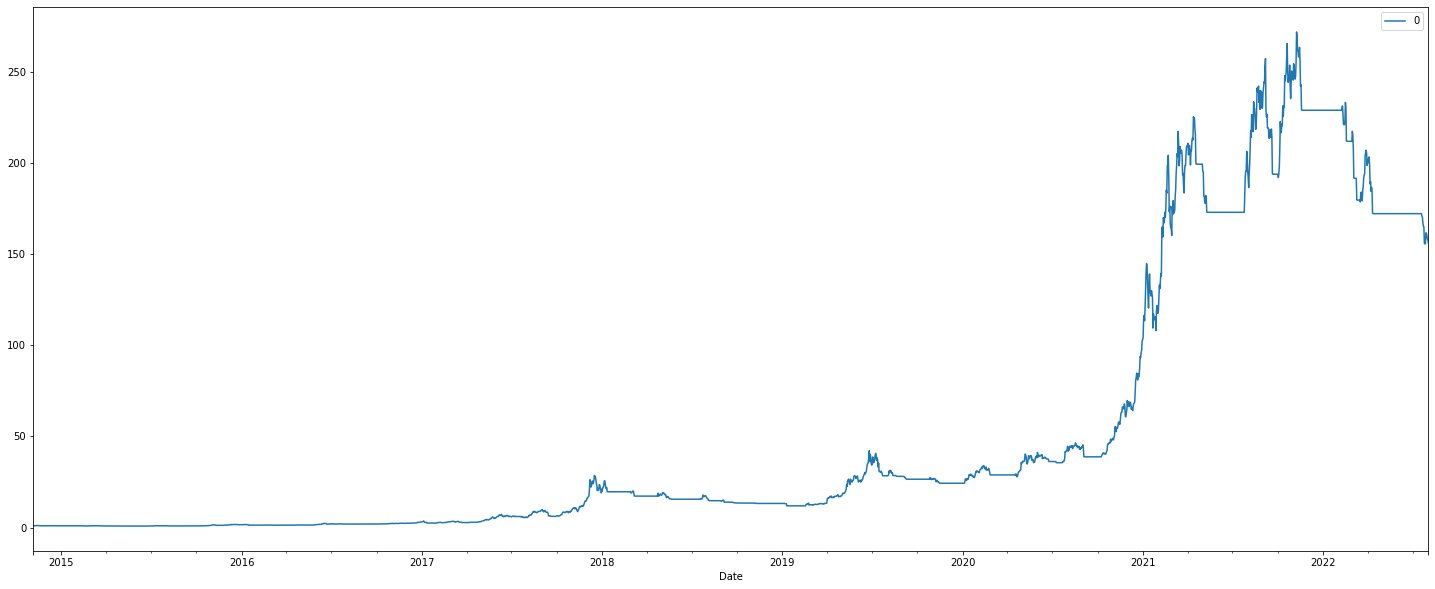

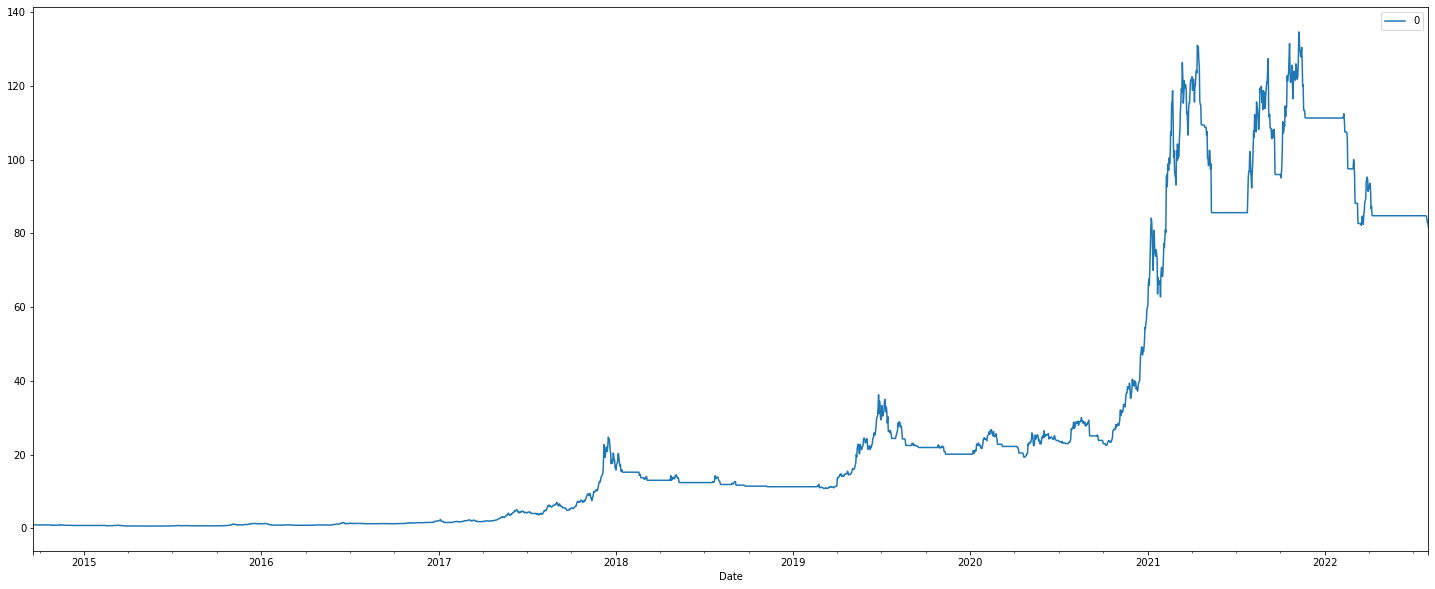

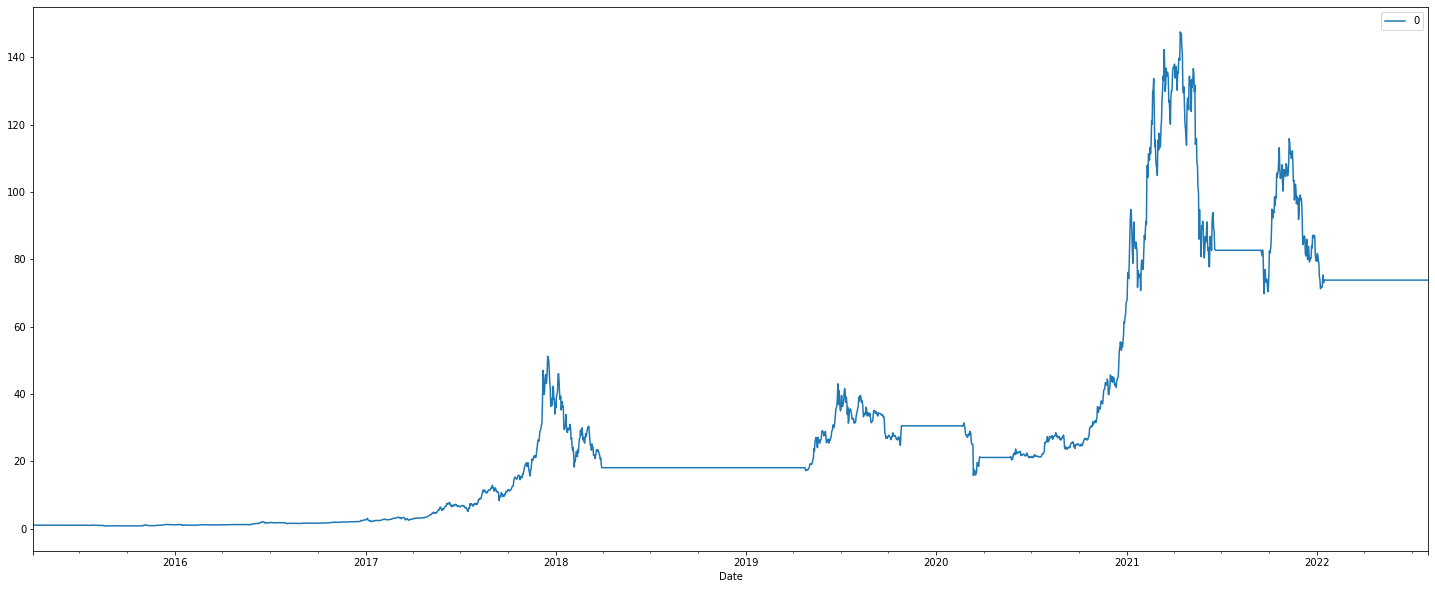

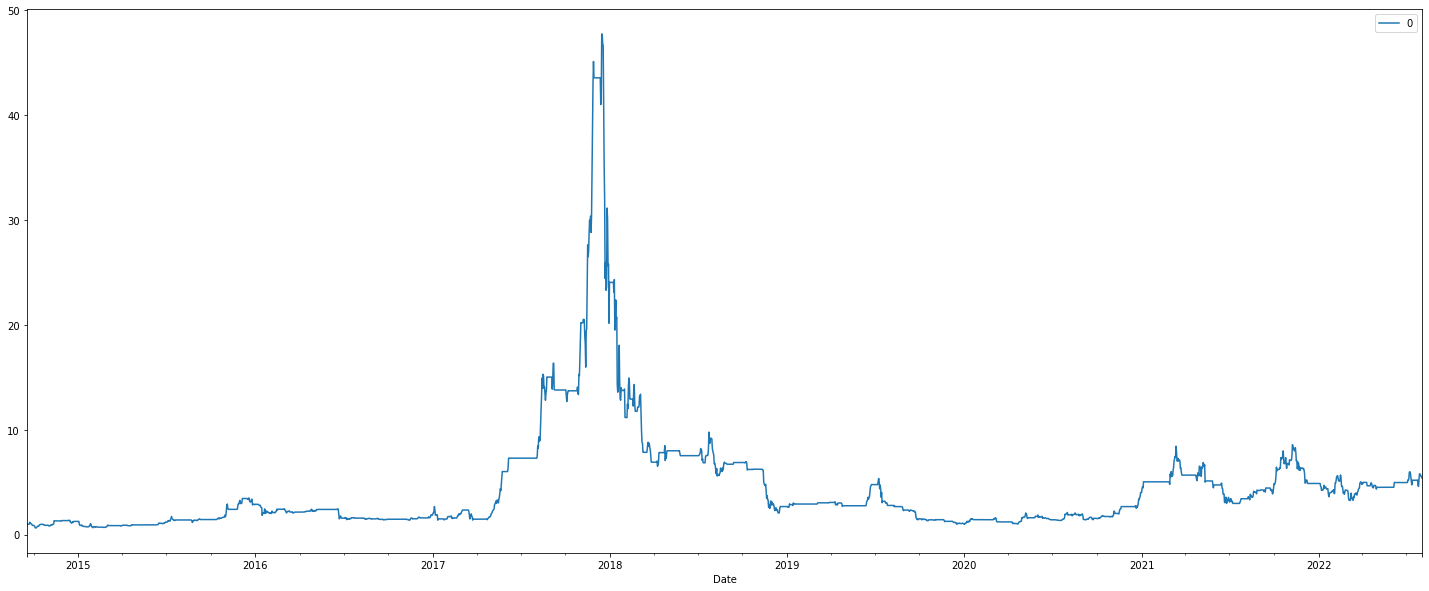

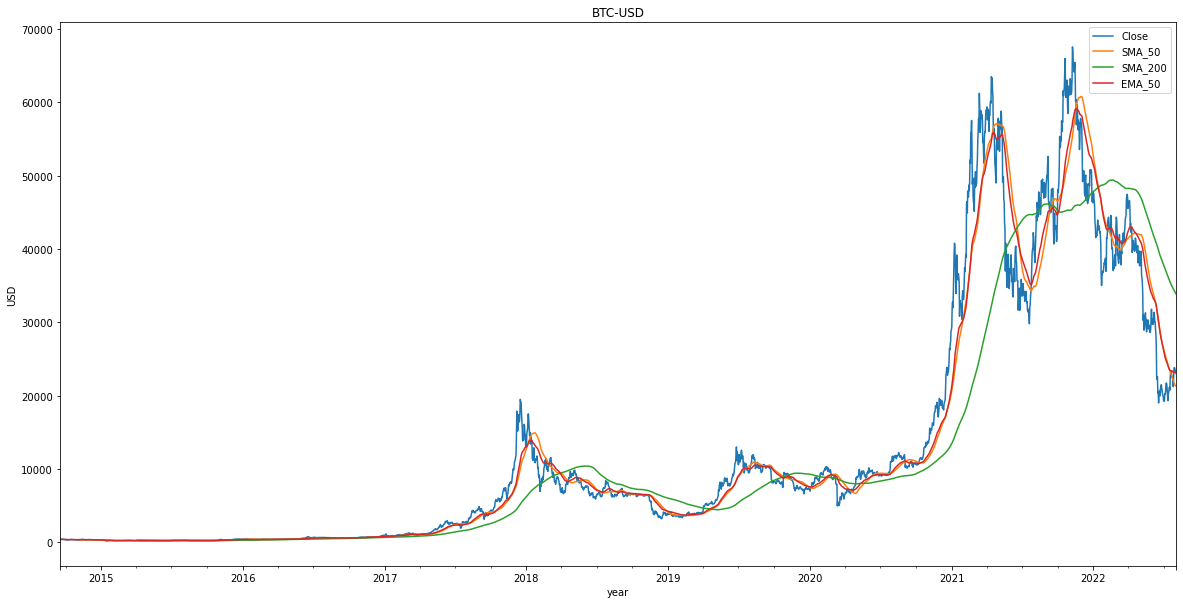

In [279]:
#now lets check the three strategies that have been encoded above to comapre them, this cell once the parameters are entered will run 
#this cell let you define all of the probailities we will be calling on 

#select the stock or coin that you want to back test against

stockname = "BTC-USD"

testperiod = "30y"

#then define the transaction cost 

tcost = 0.001

#define the short averging period used in SMA EMA and XMA 

shortdays = 50 

#define the long period used in MXA

longdays = 200

#define a tollerance variable, this says by just how much the the averages need to be above or below the close price to exercute the trade. 
#this is only implemented in the SMA and EMA where a buy will only be exercuted if the price of a stock is above the tollernce perent above the moving average 
#set to zero remove it

toll = 0.001

#lastly for the coin flip the probability of buying, probability of selling and the probability of doing nothing taken as the differnce between probbuy +probsell and 1 

probbuy = 0.1

probsell = 0.1

probdonothing = 0

runthetests()

Given that flipping a coin is random process lets test it a 1000 times just to be sure that we didnt just have a very unlucky series of rolls


The average return is: 0    3.145789
Name: 2022-08-02 00:00:00, dtype: float64
the average win rate is: 0.2645238260869565


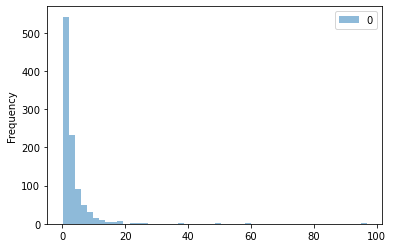

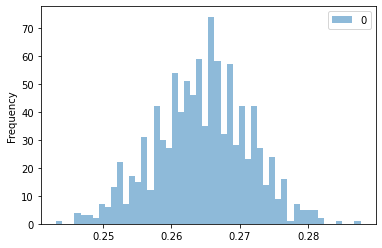

In [280]:

#run it a a bunch of times times just to be sure

trials = 1000

probbuy = 0.5

probsell = 0.5

probdonothing = 0

finalreturns = []

runningtotalwinrate = []

closedata=getdata(stockname, testperiod)

for j in range(trials):
    dfrandoms = randomtrading(closedata, probabilitybuy= probbuy,probabilitysell = probsell, probabilitydonothing = probdonothing ) 
    returnsrandom = backtester(dfrandoms['Signals'],dfrandoms['Close'])
    win = winrate(dfrandoms,returnsrandom)
    finalreturns.append(returnsrandom.iloc[-1])
    runningtotalwinrate.append(win)

# the average final return 

print('The average return is: ' + str(sum(finalreturns)/trials))

# the average win rate

print('the average win rate is: ' + str(sum(runningtotalwinrate)/trials))

#plotting a historgam to show the final returns and then the win rates

axfinalreturns = pd.DataFrame(finalreturns).plot.hist(bins=50, alpha=0.5)
axwinrates = pd.DataFrame(runningtotalwinrate).plot.hist(bins=50, alpha=0.5)